# Steady Flow Analysis

## Overview

This notebook demonstrates extracting and analyzing **steady flow** results from HEC-RAS HDF5 files. Steady flow analysis is fundamentally different from unsteady flow:

**Steady Flow**:
- Single time point (equilibrium conditions)
- Multiple flow profiles (e.g., 10-yr, 100-yr, 500-yr)
- Results organized by profile, not time
- Typical use: Floodplain mapping, bridge design, permitting

**Unsteady Flow** (see 400-series notebooks):
- Time-varying conditions
- Single or multiple events
- Results organized by time step
- Typical use: Dam breach, detention basin routing, real-time forecasting

### HDF5 Structure for Steady Flow Results

```
/Results/Steady/
├── Output/
│   ├── Geometry/               # Geometry data
│   │   └── Cross Sections/     # XS coordinates, stations
│   └── Profiles/
│       ├── Max/                # Maximum values across all profiles
│       ├── 100yr/              # 100-year flood profile
│       ├── 500yr/              # 500-year flood profile
│       └── ...                 # Other flow profiles
```

**Key Differences from Unsteady**:
- No time dimension - profiles are independent scenarios
- Profile names are user-defined (not timestamps)
- Typically used for regulatory floodplain mapping (FEMA)

### Reference Documentation

- [HEC-RAS User's Manual, Chapter 9: Viewing Results](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [HEC-RAS Hydraulic Reference Manual, Chapter 2: Steady Flow](https://www.hec.usace.army.mil/software/hec-ras/documentation.aspx)
- [FEMA Guidance for Flood Risk Analysis](https://www.fema.gov/flood-maps/tools-resources/engineering-library) - Steady flow modeling for floodplain mapping

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfResultsPlan, RasCmdr, RasExamples, init_ras_project, ras

# Additional imports
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set pandas display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

# Set to False to disable plot generation for llm-friendly outputs
generate_plots = True

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Balde Eagle Creek"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "02"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis


# HEC-RAS Steady State Flow Analysis

This notebook demonstrates how to extract and analyze steady state flow results from HEC-RAS using the ras-commander library. It showcases the new steady state functionality in `HdfResultsPlan`.

## New Steady State Methods

The library now includes full support for steady state analysis:
- `is_steady_plan()` - Check if HDF contains steady state results
- `get_steady_profile_names()` - Extract steady state profile names
- `get_steady_wse()` - Extract water surface elevations for profiles
- `get_steady_info()` - Extract steady flow metadata and attributes

## Extracting Steady Flow Computation Messages

For steady flow analyses, computation messages provide valuable information about:
- Hydraulic computations and convergence
- Warning messages for critical flow or other conditions
- Computation timing and performance

We can extract these using `HdfResultsPlan.get_compute_messages()`:

In [3]:
# Extract the Bald Eagle Creek project using suffix parameter (consistent with other notebooks)
bald_eagle_path = RasExamples.extract_project(PROJECT_NAME, suffix="19")
print(f"Extracted project to: {bald_eagle_path}")

2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Extracting project 'Balde Eagle Creek' as 'Balde Eagle Creek_19'
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Folder 'Balde Eagle Creek_19' already exists. Deleting existing folder...
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Existing folder 'Balde Eagle Creek_19' has been deleted.
2026-01-12 00:32:44 - ras_commander.RasExamples - INFO - Successfully extracted project 'Balde Eagle Creek' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\exa

Extracted project to: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19


In [4]:
plan_number = "02"

In [5]:
init_ras_project(bald_eagle_path, RAS_VERSION)

2026-01-12 00:32:44 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.rasmap
2026-01-12 00:32:44 - ras_commander.RasPrj - INFO - Updated results_df with 2 plan(s)


In [6]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,Run UNet,Run Sediment,Run PostProcess,Run WQNet,UNET Use Existing IB Tables,UNET D1 Cores,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path,flow_type
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,1,0,1,0,-1,0.0,0.0,None,dss,2,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Unsteady
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,1,NaN,1,NaN,NaN,NaN,NaN,None,dss,1,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Steady


In [7]:
RasCmdr.compute_plan(plan_number)

2026-01-12 00:32:44 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19
2026-01-12 00:32:44 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2026-01-12 00:32:44 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.prj" "C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02"
2026-01-12 00:32:49 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 02
2026-01-12 00:32:49 - ras_commander.RasCmdr - INFO - Total run time for plan 02: 4.29 seconds
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\

True

## Extracting Steady Flow Computation Messages

For steady flow analyses, computation messages provide valuable information about:
- Hydraulic computations and convergence
- Warning messages for critical flow or other conditions
- Computation timing and performance

We can extract these using `HdfResultsPlan.get_compute_messages()`:

In [8]:
ras.plan_df

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,Run UNet,Run Sediment,Run PostProcess,Run WQNet,UNET Use Existing IB Tables,UNET D1 Cores,UNET D2 Cores,PS Cores,DSS File,Friction Slope Method,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,01,02,01,Unsteady with Bridges and Dam,5.00,UnsteadyFlow,"18FEB1999,0000,24FEB1999,0500",2MIN,1HOUR,1,1,0,1,0,-1,0.0,0.0,None,dss,2,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,02,None,01,Steady Flow Run,NaN,SteadyRun,"02/18/1999,0000,02/24/1999,0500",2MIN,NaN,1,1,NaN,1,NaN,NaN,NaN,NaN,None,dss,1,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [9]:
RasCmdr.compute_plan(plan_number, "6.6")

2026-01-12 00:32:49 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19
2026-01-12 00:32:49 - ras_commander.RasCmdr - ERROR - Destination folder 'C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\6.6' exists and is not empty. Use overwrite_dest=True to overwrite.
2026-01-12 00:32:49 - ras_commander.RasCmdr - CRITICAL - Error in compute_plan: Destination folder 'C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\6.6' exists and is not empty. Use overwrite_dest=True to overwrite.


False

In [10]:
# Extract computation messages for steady flow analysis
from ras_commander import HdfResultsPlan

print("="*80)
print("STEADY FLOW COMPUTATION MESSAGES")
print("="*80)

# Extract messages (works with plan number or HDF path)
steady_msgs = HdfResultsPlan.get_compute_messages(plan_number)

if steady_msgs:
    print(f"\nExtracted {len(steady_msgs)} characters\n")
    
    # Display messages
    print("Computation messages:")
    print("-" * 80)
    print(steady_msgs[:1000])  # First 1000 characters
    
    if len(steady_msgs) > 1000:
        print("\n... (truncated for display) ...")
    
    # Look for critical information
    print("\n" + "="*80)
    print("Checking for critical flow or warnings...")
    print("="*80)
    
    lines = steady_msgs.split('\n')
    critical = [l for l in lines if 'critical' in l.lower() or 'warning' in l.lower()]
    
    if critical:
        print(f"Found {len(critical)} lines with critical flow or warnings:")
        for line in critical[:10]:
            print(f"  - {line.strip()}")
    else:
        print("✓ No critical flow or warning messages found")
else:
    print("No computation messages available")

print("\n" + "="*80)

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 718 characters from HDF


STEADY FLOW COMPUTATION MESSAGES

Extracted 718 characters

Computation messages:
--------------------------------------------------------------------------------
Plan: 'Steady Flow Run' (BaldEagle.p02)
Simulation started at: 12Jan2026 12:32:45 AM

Writing Plan GIS Data...
Completed Writing Plan GIS Data
Writing Geometry...
Computing Bank Lines
Bank lines generated in 106 ms
Computing Edge Lines
Edge Lines generated in 40 ms
Computing XS Interpolation Surface
XS Interpolation Surface generated in 106 ms
Completed Writing Geometry
Writing Event Conditions ...
Completed Writing Event Condition Data

	
Steady Flow Simulation HEC-RAS 6.6 September 2024
 

Finished Steady Flow Simulation


Computations Summary

Computation Task	Time(hh:mm:ss)
Completing Geometry, Flow and Plan	       1
Steady Flow Computations	       1
Complete Process	       2


Checking for critical flow or warnings...
✓ No critical flow or warning messages found



## Package Installation and Environment Setup

In [11]:
# Install ras-commander from pip (uncomment to install if needed)
# !pip install --upgrade ras-commander

# Set to False to disable plot generation for llm-friendly outputs
generate_plots = True

In [12]:
# Import required modules
from ras_commander import HdfResultsPlan, RasCmdr, RasExamples, init_ras_project, ras

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set pandas display options
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

In [13]:
# The Bald Eagle Creek project was already extracted and initialized in cells 4-6 above
# bald_eagle_path is already defined and ras object is already initialized
# This cell just confirms the setup for the steady state analysis section

print(f"Project path: {bald_eagle_path}")
print(f"Project initialized: {ras.project_name}")

Project path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19
Project initialized: BaldEagle


## Run Steady State Plan (Plan 02)

Execute the steady state plan if results don't already exist.

In [14]:
# Define plan number
plan_number = PLAN

# Execute the steady state plan with skip_existing=True
# This will skip execution if HDF results already exist with "Complete Process"
print(f"Running Plan {plan_number} (Steady State)...")
success = RasCmdr.compute_plan(plan_number, skip_existing=True)
if success:
    print(f"Plan {plan_number} executed successfully (or skipped - results exist)")
else:
    print(f"Plan {plan_number} execution failed")


2026-01-12 00:32:49 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 718 characters from HDF
2026-01-12 00:32:49 - ras_commander.RasCmdr - INFO - Skipping plan 02: HDF results already exist with 'C

Running Plan 02 (Steady State)...
Plan 02 executed successfully (or skipped - results exist)


## 1. Check if Plan Contains Steady State Results

Use `is_steady_plan()` to verify the HDF contains steady state results.

In [15]:
# Check if this is a steady state plan
is_steady = HdfResultsPlan.is_steady_plan(plan_number)
print(f"Is Plan {plan_number} a steady state plan? {is_steady}")

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf


Is Plan 02 a steady state plan? True


## 2. Extract Steady State Profile Names

Get the list of all steady state profiles (e.g., different return periods).

In [16]:
# Get profile names
profiles = HdfResultsPlan.get_steady_profile_names(plan_number)

print(f"Found {len(profiles)} steady state profiles:")
for i, profile in enumerate(profiles, 1):
    print(f"  {i}. {profile}")

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Found 8 steady state profiles: ['.5 year', '1 year', '2 year', '5 year', '10 year', '25 year', '50 year', '100 year']


Found 8 steady state profiles:
  1. .5 year
  2. 1 year
  3. 2 year
  4. 5 year
  5. 10 year
  6. 25 year
  7. 50 year
  8. 100 year


## 3. Extract Water Surface Elevations (WSE)

Extract WSE data for specific profiles or all profiles at once.

### 3a. Extract Single Profile by Name

In [17]:
# Extract WSE for 100-year profile
wse_100yr = HdfResultsPlan.get_steady_wse(plan_number, profile_name='100 year')

print(f"WSE Data for 100-year profile:")
print(f"Shape: {wse_100yr.shape}")
print(f"Columns: {list(wse_100yr.columns)}")
print("\nFirst 5 cross sections:")
wse_100yr.head()

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted WSE data for 1 profile(s), 178 cross sections


WSE Data for 100-year profile:
Shape: (178, 4)
Columns: ['River', 'Reach', 'Station', 'WSE']

First 5 cross sections:


,River,Reach,Station,WSE
0,Bald Eagle,Loc Hav,138154.4,669.521484
1,Bald Eagle,Loc Hav,137690.8,669.346863
2,Bald Eagle,Loc Hav,137327.0,668.883057
3,Bald Eagle,Loc Hav,136564.9,666.177979
4,Bald Eagle,Loc Hav,136202.3,666.057739


### 3b. Extract Single Profile by Index

In [18]:
# Extract WSE for first profile (0.5-year) using index
wse_05yr = HdfResultsPlan.get_steady_wse(plan_number, profile_index=0)

print(f"WSE Data for {profiles[0]} profile:")
print(f"Shape: {wse_05yr.shape}")
print("\nSummary statistics:")
wse_05yr['WSE'].describe()

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted WSE data for 1 profile(s), 178 cross sections


WSE Data for .5 year profile:
Shape: (178, 4)

Summary statistics:


count    178.000000
mean     590.215864
std       39.202902
min      537.500000
25%      557.109406
50%      579.655151
75%      623.142242
max      660.588928
Name: WSE, dtype: float64

### 3c. Extract All Profiles

In [19]:
# Extract WSE for all profiles
wse_all = HdfResultsPlan.get_steady_wse(plan_number)

print(f"WSE Data for all {len(profiles)} profiles:")
print(f"Shape: {wse_all.shape}")
print(f"Columns: {list(wse_all.columns)}")
print(f"\nProfiles included: {wse_all['Profile'].unique().tolist()}")
print("\nSample data:")
wse_all.head(10)

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted WSE data for 8 profile(s), 178 cross sections


WSE Data for all 8 profiles:
Shape: (1424, 5)
Columns: ['River', 'Reach', 'Station', 'Profile', 'WSE']

Profiles included: ['.5 year', '1 year', '2 year', '5 year', '10 year', '25 year', '50 year', '100 year']

Sample data:


,River,Reach,Station,Profile,WSE
0,Bald Eagle,Loc Hav,138154.4,.5 year,660.588928
1,Bald Eagle,Loc Hav,137690.8,.5 year,659.914612
2,Bald Eagle,Loc Hav,137327.0,.5 year,659.465759
3,Bald Eagle,Loc Hav,136564.9,.5 year,658.126160
4,Bald Eagle,Loc Hav,136202.3,.5 year,657.173157
5,Bald Eagle,Loc Hav,135591.4,.5 year,656.520264
6,Bald Eagle,Loc Hav,135068.7,.5 year,655.880676
7,Bald Eagle,Loc Hav,134487.2,.5 year,654.593140
8,Bald Eagle,Loc Hav,133881.0,.5 year,653.786621
9,Bald Eagle,Loc Hav,133446.1,.5 year,653.006958


## 4. Extract Steady Flow Metadata

Get plan information, program version, solution status, and flow file details.

In [20]:
# Get steady flow information
steady_info = HdfResultsPlan.get_steady_info(plan_number)

print(f"Steady Flow Information ({len(steady_info.columns)} attributes):")
print("\nKey attributes:")
for col in ['Program Version', 'Solution', 'Flow Title', 'Flow Filename']:
    if col in steady_info.columns:
        print(f"  {col}: {steady_info[col].values[0]}")

print("\nAll attributes:")
steady_info.T

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Extracted 8 steady state attributes


Steady Flow Information (8 attributes):

Key attributes:
  Program Version: HEC-RAS 6.6 September 2024
  Solution: Steady Finished Successfully
  Flow Title: Steady Flow Data
  Flow Filename: BaldEagle.f02

All attributes:


,0
Program Name,HEC-RAS - River Analysis System
Program Version,HEC-RAS 6.6 September 2024
Project File Name,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
Type of Run,Steady Flow Analysis
Run Time Window,12JAN2026 00:32:47 to 12JAN2026 00:32:48
Solution,Steady Finished Successfully
Flow Filename,BaldEagle.f02
Flow Title,Steady Flow Data


## 5. Visualize Water Surface Profiles

Plot WSE vs. station for different return periods.

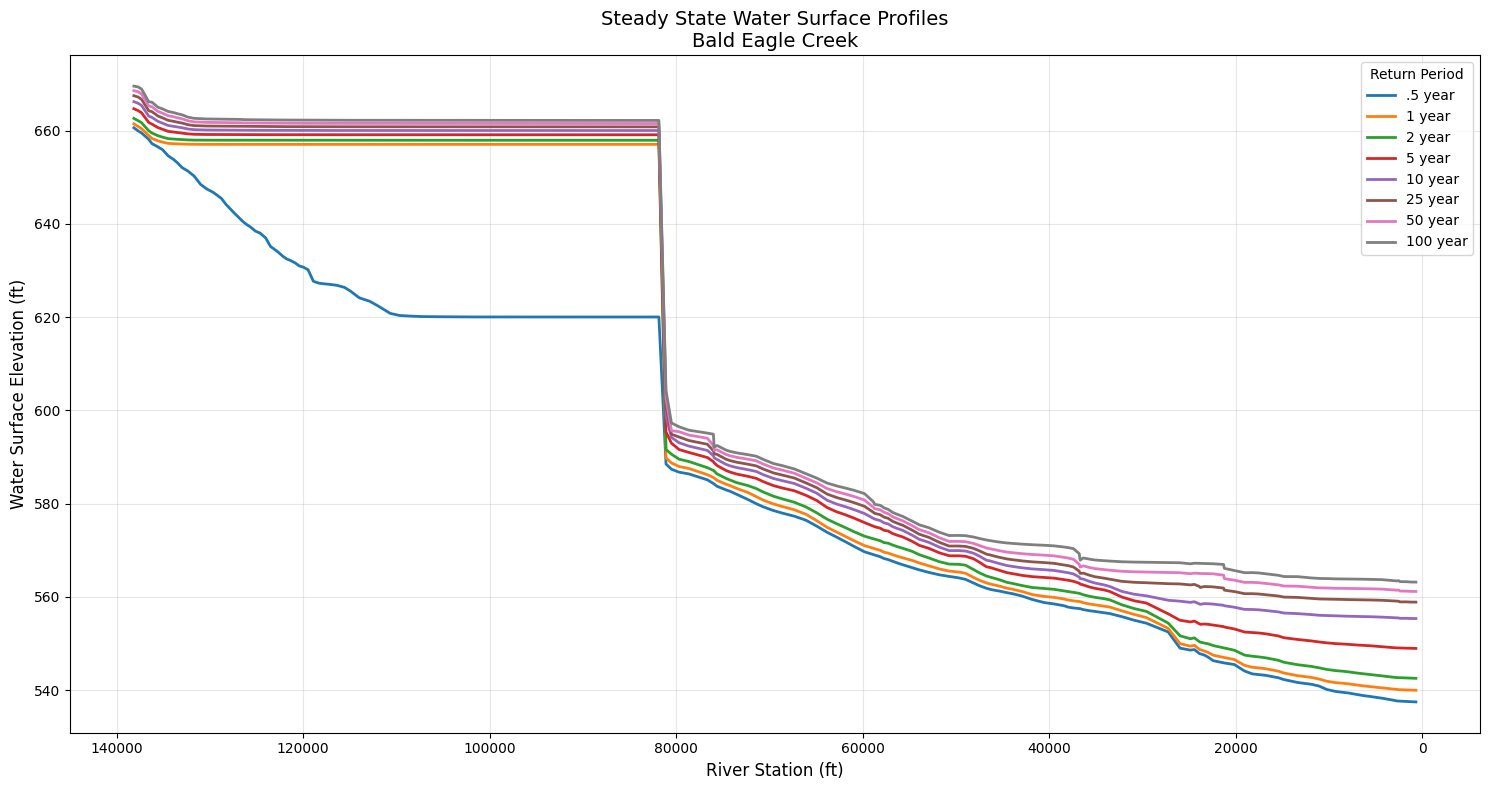


Profile Comparison (Maximum WSE):
  .5 year   : 660.59 ft
  1 year    : 661.43 ft
  2 year    : 662.60 ft
  5 year    : 664.67 ft
  10 year   : 666.19 ft
  25 year   : 667.46 ft
  50 year   : 668.54 ft
  100 year  : 669.52 ft


In [21]:
if generate_plots:
    # Create a plot comparing all profiles
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot each profile
    for profile in profiles:
        profile_data = wse_all[wse_all['Profile'] == profile]
        # Convert station to numeric for plotting
        stations = pd.to_numeric(profile_data['Station'], errors='coerce')
        ax.plot(stations, profile_data['WSE'], label=profile, linewidth=2)
    
    ax.set_xlabel('River Station (ft)', fontsize=12)
    ax.set_ylabel('Water Surface Elevation (ft)', fontsize=12)
    ax.set_title('Steady State Water Surface Profiles\nBald Eagle Creek', fontsize=14)
    ax.legend(title='Return Period', loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Invert X axis so upstream (higher stations) is on the left
    ax.invert_xaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Print profile comparison stats
    print("\nProfile Comparison (Maximum WSE):")
    for profile in profiles:
        max_wse = wse_all[wse_all['Profile'] == profile]['WSE'].max()
        print(f"  {profile:10s}: {max_wse:.2f} ft")

## 6. Analyze WSE Differences Between Profiles

Compare water surface elevations between different return periods.

In [22]:
# Create a pivot table for easy comparison
wse_pivot = wse_all.pivot_table(
    index=['River', 'Reach', 'Station'],
    columns='Profile',
    values='WSE'
)

print("Water Surface Elevations by Profile and Station:")
print("\nFirst 10 stations:")
wse_pivot.head(10)

Water Surface Elevations by Profile and Station:

First 10 stations:


Profile                         .5 year      1 year     10 year    100 year  \
River      Reach   Station                                                    
Bald Eagle Loc Hav 100657.3  620.031982  657.029053  660.006348  662.170227   
                   101440.3  620.033875  657.029053  660.006470  662.170593   
                   10221.14  540.174683  541.939697  556.019287  563.945190   
                   103122.3  620.044861  657.029053  660.006836  662.171753   
                   103369.7  620.055420  657.029480  660.012878  662.186707   
                   103854.0  620.059082  657.029480  660.012939  662.187012   
                   104195.0  620.059875  657.029480  660.012878  662.186829   
                   104647.2  620.066528  657.029480  660.013000  662.187378   
                   105178.6  620.075806  657.029480  660.013367  662.188599   
                   106466.0  620.093262  657.029419  660.013428  662.188782   

Profile                          2 year     25 year      5 year     50 year  
River      Reach   Station                                                   
Bald Eagle Loc Hav 100657.3  657.916138  660.793945  659.094055  661.508545  
                   101440.3  657.916138  660.794067  659.094116  661.508850  
                   10221.14  544.468933  559.538452  550.165833  561.924500  
                   103122.3  657.916138  660.794678  659.094299  661.509705  
                   103369.7  657.917175  660.803711  659.097473  661.521729  
                   103854.0  657.917175  660.803894  659.097534  661.521973  
                   104195.0  657.917175  660.803772  659.097473  661.521790  
                   104647.2  657.917175  660.804077  659.097595  661.522217  
                   105178.6  657.917175  660.804688  659.097717  661.523071  
                   106466.0  657.917236  660.804871  659.097778  661.523315

In [23]:
# Calculate differences between profiles
if '100 year' in wse_pivot.columns and '.5 year' in wse_pivot.columns:
    wse_pivot['Diff_100yr_vs_05yr'] = wse_pivot['100 year'] - wse_pivot['.5 year']
    
    print("\nDifference between 100-year and 0.5-year profiles:")
    print(f"  Maximum difference: {wse_pivot['Diff_100yr_vs_05yr'].max():.2f} ft")
    print(f"  Minimum difference: {wse_pivot['Diff_100yr_vs_05yr'].min():.2f} ft")
    print(f"  Average difference: {wse_pivot['Diff_100yr_vs_05yr'].mean():.2f} ft")
    
    print("\nStations with largest differences:")
    top_diff = wse_pivot.nlargest(5, 'Diff_100yr_vs_05yr')[['100 year', '.5 year', 'Diff_100yr_vs_05yr']]
    print(top_diff)


Difference between 100-year and 0.5-year profiles:
  Maximum difference: 42.14 ft
  Minimum difference: 7.90 ft
  Average difference: 21.62 ft

Stations with largest differences:
Profile                        100 year     .5 year  Diff_100yr_vs_05yr
River      Reach   Station                                             
Bald Eagle Loc Hav 96370.43  662.169006  620.027832           42.141174
                   94560.01  662.168457  620.027466           42.140991
                   93391.71  662.167664  620.027283           42.140381
                   97607.35  662.168640  620.028320           42.140320
                   98206.87  662.169983  620.029846           42.140137


## 7. Discover Available Steady State Variables

Use `list_steady_variables()` to explore what data is available in steady state results before extraction. This is essential for understanding the full scope of available outputs.

## Summary

This notebook demonstrated the new steady state functionality in ras-commander:

1. Checked if a plan contains steady state results
2. Extracted profile names for different return periods
3. Retrieved WSE data for individual and all profiles
4. Accessed steady flow metadata and attributes
5. Visualized water surface profiles
6. Analyzed differences between profiles
7. **Discovered available steady state variables** using `list_steady_variables()`

These tools enable comprehensive steady state flow analysis and comparison of hydraulic conditions across different design storms or flow scenarios.

## Common Steady Flow Analysis Patterns

### Pattern 1: Compare Profiles at Single Location

```python
# Extract WSE for all profiles at critical cross section
critical_xs = "10500"
profile_comparison = wse_df.loc[critical_xs, :]

# Plot profile comparison
profile_comparison.plot(kind='bar', title=f'WSE at XS {critical_xs}')
```

### Pattern 2: Identify Critical Cross Sections

```python
# Find XS with highest WSE increase between 100yr and 500yr
wse_increase = wse_df['500yr'] - wse_df['100yr']
critical_locations = wse_increase.nlargest(10)

# These locations may need additional mitigation
```

### Pattern 3: Energy Grade Line Analysis

```python
# Extract energy grade line (WSE + velocity head)
egl = wse + (velocity**2) / (2 * 32.2)  # g = 32.2 ft/s²

# Verify positive slope downstream
egl_slope = egl.diff()  # Should be positive
```

### Pattern 4: Floodplain Delineation

```python
# Identify cross sections where 100yr WSE exceeds bank elevation
overbank_xs = wse_df[wse_df['100yr'] > bank_elevation]

# Export for GIS mapping
overbank_xs.to_csv('overbank_locations_100yr.csv')
```

## Cross-References

- **Unsteady 1D**: See `400_1d_hdf_data_extraction.ipynb` for time-varying 1D results
- **2D Steady**: See `410_2d_hdf_data_extraction.ipynb` (can also handle steady 2D)
- **Hydraulic Tables**: HEC-RAS can export hydraulic property tables for each XS

In [24]:
# Discover all available steady state variables in the HDF results
steady_vars = HdfResultsPlan.list_steady_variables(plan_number)

print("="*80)
print("STEADY STATE VARIABLE DISCOVERY")
print("="*80)

print(f"\n📊 Cross Section Variables ({len(steady_vars['cross_sections'])}):")
for var in sorted(steady_vars['cross_sections']):
    print(f"   • {var}")

print(f"\n📈 Additional Variables ({len(steady_vars['additional'])}):")
for var in sorted(steady_vars['additional']):
    print(f"   • {var}")

if steady_vars['structures']:
    print(f"\n🌉 Structure Variables ({len(steady_vars['structures'])}):")
    for var in sorted(steady_vars['structures']):
        print(f"   • {var}")
else:
    print("\n🌉 Structure Variables: None found (no inline structures)")

print("\n" + "="*80)
print("Use these variable names when querying specific hydraulic outputs.")
print("="*80)

2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Balde Eagle Creek_19\BaldEagle.p02.hdf
2026-01-12 00:32:49 - ras_commander.hdf.HdfResultsPlan - INFO - Found 3 XS vars, 53 additional vars, 0 structure vars


STEADY STATE VARIABLE DISCOVERY

📊 Cross Section Variables (3):
   • Energy Grade
   • Flow
   • Water Surface

📈 Additional Variables (53):
   • Alpha
   • Area Flow Channel
   • Area Flow Left OB
   • Area Flow Right OB
   • Area Flow Total
   • Area including Ineffective Channel
   • Area including Ineffective Left OB
   • Area including Ineffective Right OB
   • Area including Ineffective Total
   • Beta
   • Conveyance Channel
   • Conveyance Left OB
   • Conveyance Right OB
   • Conveyance Total
   • Critical Energy Grade
   • Critical Water Surface
   • EG Slope
   • Flow Channel
   • Flow Left OB
   • Flow Right OB
   • Flow Total
   • Friction Slope
   • Hydraulic Depth Channel
   • Hydraulic Depth Left OB
   • Hydraulic Depth Right OB
   • Hydraulic Depth Total
   • Hydraulic Radius Channel
   • Hydraulic Radius Left OB
   • Hydraulic Radius Right OB
   • Hydraulic Radius Total
   • Manning n Channel
   • Manning n Left OB
   • Manning n Right OB
   • Manning n Total
   • Max